# A deep learning image classifier web application
A model to detect whether an image contains a smiling person or not, created following the [From Model to Production](https://github.com/fastai/fastbook/blob/master/02_production.ipynb) chapter of [the fastai book](https://github.com/fastai/fastbook).

In [1]:
!pip install -Uqq fastbook

import fastbook
import urllib
import zipfile

from pathlib import Path
from fastbook import *
from fastai.vision.all import *

     |████████████████████████████████| 727kB 21.4MB/s 
     |████████████████████████████████| 1.2MB 24.9MB/s 
     |████████████████████████████████| 194kB 48.8MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 251kB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.


# Getting images
Our images are contained in a zip file - images with smiles under a 'yes' folder, and images without smiles in a 'no' folder':

In [34]:
IMAGE_ZIP_URL = "https://github.com/fornwall/first-image-classifier/releases/download/dataset1/smiles.zip"

# untar_data from fastai supports zip files, but flattens files when unzipping
extract_dir = Path.home()/"smiles"
zip_path, _ = urllib.request.urlretrieve(IMAGE_ZIP_URL)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)

print(f"Images with a smile: {len((extract_dir/'yes').ls())}")
print(f"Images without smile: {len((extract_dir/'no').ls())}")

Images with a smile: 61
Images without smile: 99


Let's view a random sample of one smiling and one non-smiling image:

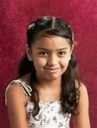

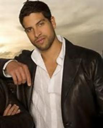

In [13]:
import random
from IPython.display import display

example = random.choice((Path(extract_dir)/"yes").ls())
display(Image.open(example).to_thumb(128,128))
example = random.choice((Path(extract_dir)/"no").ls())
display(Image.open(example).to_thumb(128,128))

Our folder has image files, as we'd expect:

In [14]:
image_files = get_image_files(extract_dir)
# verify_images() returns a list of invalid images, so we assert that no image is invalid:
assert not verify_images(image_files)
image_files

(#160) [Path('/root/smiles/yes/75_1_0_20170110140824258.jpg'),Path('/root/smiles/yes/23_1_3_20170109132112364.jpg'),Path('/root/smiles/yes/16_1_0_20170109214415828.jpg'),Path('/root/smiles/yes/24_1_0_20170105183618095.jpg'),Path('/root/smiles/yes/76_0_0_20170111171747674.jpg'),Path('/root/smiles/yes/82_0_2_20170111210612356.jpg'),Path('/root/smiles/yes/90_1_0_20170110183401767.jpg'),Path('/root/smiles/yes/6_1_0_20170109201721681.jpg'),Path('/root/smiles/yes/8_1_0_20170109203315965.jpg'),Path('/root/smiles/yes/3_1_0_20170109191231140.jpg')...]

In [15]:
image_block = DataBlock(
    # Tuple specifying types for the independent (images) and dependent (categories, 'yes' or 'no') variables:
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    # Split training and validation set randomly:
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # Get the dependent variable from the parent directory name:
    get_y=parent_label,
    item_tfms=Resize(128))

loaders = image_block.dataloaders(extract_dir)

A `DataLoaders` includes validation and training `DataLoader`s. `DataLoader` is a class that provides batches of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a `DataLoader` fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a `DataLoader`:

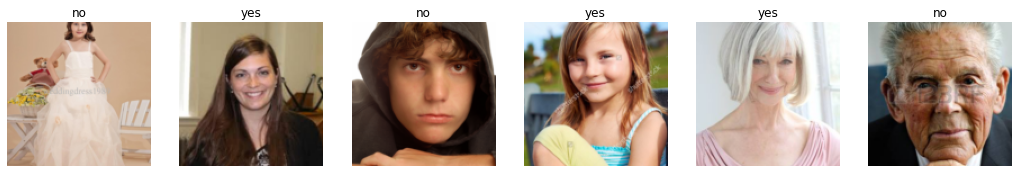

In [16]:
loaders.valid.show_batch(max_n=6, nrows=1)

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to squish/stretch them:

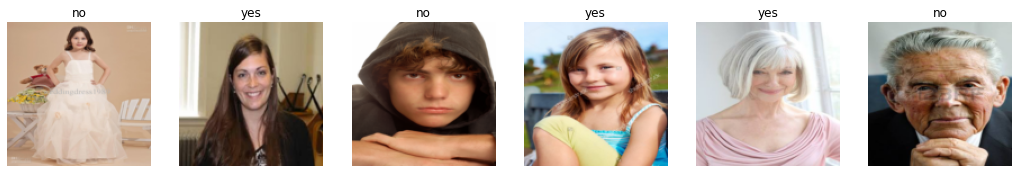

In [17]:
squishing_image_block = image_block.new(item_tfms=Resize(128, ResizeMethod.Squish))
squishing_loaders = squishing_image_block.dataloaders(extract_dir)
squishing_loaders.valid.show_batch(max_n=6, nrows=1)

Or zero pad them:

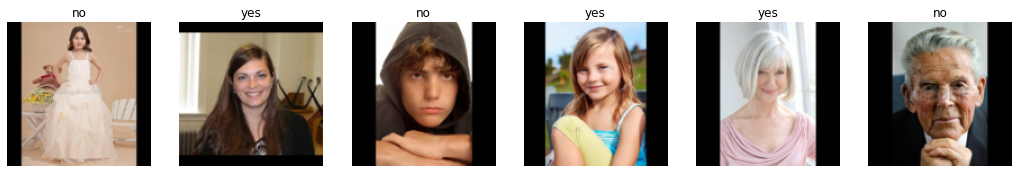

In [18]:
padding_image_block = image_block.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
padding_loaders = padding_image_block.dataloaders(extract_dir)
padding_loaders.valid.show_batch(max_n=6, nrows=1)

All of these approaches seem somewhat wasteful, or problematic. If we squish or stretch the images they end up as unrealistic shapes, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. If we crop the images then we remove some of the features that allow us to perform recognition. For instance, if we were trying to recognize breeds of dog or cat, we might end up cropping out a key part of the body or the face necessary to distinguish between similar breeds. If we pad the images then we have a whole lot of empty space, which is just wasted computation for our model and results in a lower effective resolution for the part of the image we actually use.

Instead, what we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

In fact, an entirely untrained neural network knows nothing whatsoever about how images behave. It doesn't even recognize that when an object is rotated by one degree, it still is a picture of the same thing! So actually training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

Here's another example where we replace `Resize` with `RandomResizedCrop`, which is the transform that provides the behavior we just described. The most important parameter to pass in is `min_scale`, which determines how much of the image to select at minimum each time:

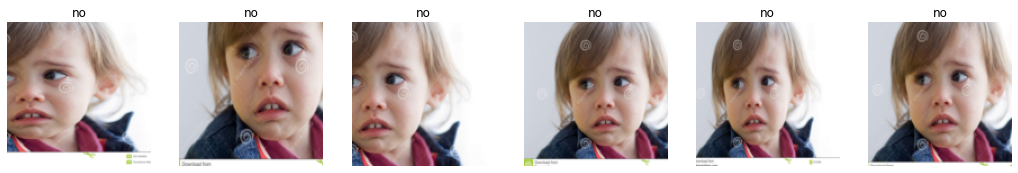

In [19]:
cropping_image_block = image_block.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
cropping_loaders = cropping_image_block.dataloaders(extract_dir)
cropping_loaders.train.show_batch(max_n=6, nrows=1, unique=True)

We used `unique=True` to have the same image repeated with different versions of this `RandomResizedCrop` transform. This is a specific example of a more general technique, called data augmentation.

*Data augmentation* refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the `aug_transforms` function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the `batch_tfms` parameter (note that we're not using `RandomResizedCrop` in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):

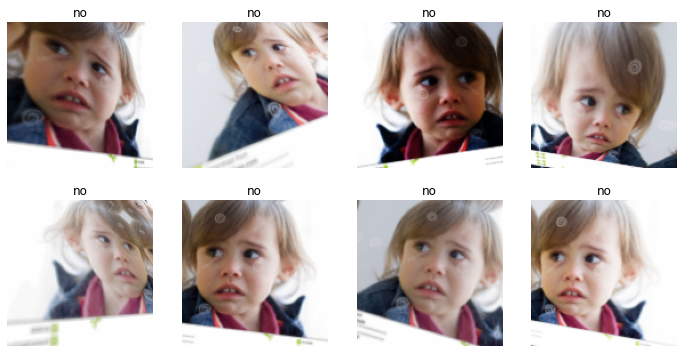

In [21]:
augmenting_image_block = image_block.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
augmenting_loaders = augmenting_image_block.dataloaders(extract_dir)
augmenting_loaders.train.show_batch(max_n=8, nrows=2, unique=True)

Now that we have assembled our data in a format fit for model training, let's actually train an image classifier using it.

## Training Your Model, and Using It to Clean Your Data

Time to use the same lines of code as in <<chapter_intro>> to train our bear classifier.

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [22]:
production_image_block = image_block.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
production_loaders = production_image_block.dataloaders(extract_dir)

We can now create our `Learner` and fine-tune it in the usual way:

In [23]:
learner = cnn_learner(production_loaders, arch=resnet18, metrics=error_rate)
learner.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.402292,0.861112,0.500000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.108380,0.726156,0.375000,00:03
1,1.008521,0.739909,0.437500,00:03
2,0.937476,0.839803,0.312500,00:03
3,0.828712,0.931444,0.437500,00:03


Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a *confusion matrix*:

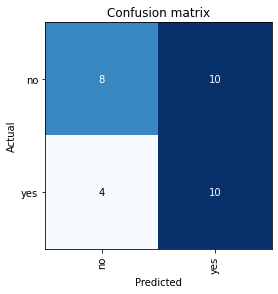

In [24]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

The rows represent all the black, grizzly, and teddy bears in our dataset, respectively. The columns represent the images which the model predicted as black, grizzly, and teddy bears, respectively. Therefore, the diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly. This is one of the many ways that fastai allows you to view the results of your model. It is (of course!) calculated using the validation set. With the color-coding, the goal is to have white everywhere except the diagonal, where we want dark blue. Our bear classifier isn't making many mistakes!

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't bears at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their *loss*.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. In a couple of chapters we'll learn in depth how loss is calculated and used in the training process. For now, `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction:

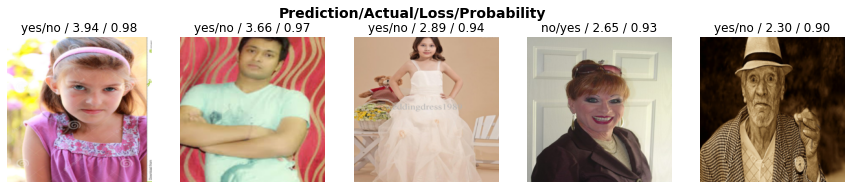

In [25]:
interp.plot_top_losses(5, nrows=1)

### Using the Model for Inference

Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the *architecture* and the trained *parameters*. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the `export` method.

This method even saves the definition of how to create your `DataLoaders`. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set `DataLoader` for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call `export`, fastai will save a file called "export.pkl":

In [26]:
learner.export()

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [28]:
exported_file = Path().ls(file_exts='.pkl')[0]
exported_file

Path('export.pkl')

Let's download it:

In [29]:
from google.colab import files
files.download(exported_file) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>